#### Applied Machine Learning - Mini Project 5 (Tasnim Ahmed, ta1743)

In [1]:
import sklearn 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
## Avoid printing out warnings
with warnings.catch_warnings():
     warnings.filterwarnings("ignore")

#### Loading the Dataset

In [3]:
from sklearn.datasets import load_digits   
digits = load_digits()

In [4]:
X = digits.data   # shape = (1797, 64)
y = digits.target # shape = (1797,)

#### Visualizing the Dataset

<Figure size 432x288 with 0 Axes>

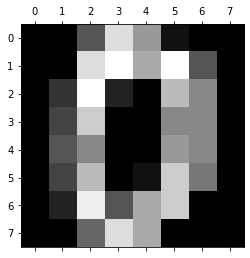

In [5]:
plt.gray()
plt.matshow(digits.images[0])

#### OneHot Encoding Function

In [6]:
# convert the labels with one hot encoding
def oneHotEncoding(Y):
    y_encoded = []
    for i in range(Y.shape[0]):
        y = np.zeros((10))
        y[Y[i]] = 1
        y_encoded.append(y)
        
    return np.array(y_encoded)

In [7]:
# Enconding the labels
y_encoded = oneHotEncoding(y)  # shape = (1797, 10)

#### Scaling and Splitting the Dataset

In [8]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [9]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.33)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1203, 64)
(1203, 10)
(594, 64)
(594, 10)


#### Implementation of the activation function and their derivative

In [11]:
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

def sigmoid_derivative(Z):
    dA = sigmoid(Z)*(1 - sigmoid(Z))
    return dA

def tanh(Z):
    A = np.tanh(Z)
    return A

def tanh_derivative(Z):
    df = 1 - (tanh(Z)**2)
    return df

def ReLu(Z):
    return np.maximum(0, Z)

def ReLu_derivative(Z):
    Z = np.where(Z < 0, 0, Z)
    Z = np.where(Z >= 0, 1, Z)
    return Z 

### NN: Forward and Backward Propagatation Implementation

In [12]:
# This is a 2 layer neural network - because we do calculations only for input-hidden and hidden-output

# W is the weight matrix for layer l
# b is the bias vector for layer l
        
# Z = W.X + b
# g - the activation function applied on layer l
# A - output after applying activation (g(Z))

# L - number of layers, not including the input layer (2)
# n - number of nodes in layers 1 (input: 64, hidden: 30, output: 10)
# m - number of samples in the dataset


# DIMENSIONS of the vectors and the arrays

# W, dW - (# of nodes in l) x (# of nodes in l-1) [input-hidden: (30x64), hidden-output: (10x30)]
# b, db - (# of nodes in l) x (1) [vector]
# Z, dZ - (# of nodes in l) x (number of examples????)
# A, dA - (# of nodes in l) x (number of examples????)

class NNClassifier:
    def __init__(self, n_layers, nn_structure, activation_func, derivation):
        self.n_layers = n_layers
        self.nn_structure = nn_structure
        self.activation = activation_func
        self.derivative = derivation  
        
    #initialize the parameters: the weight and the bias
    def initialize_parameters(self):
        W = {}
        b = {}
        for i in range(self.n_layers):
            W[i] = np.random.randn(self.nn_structure[i+1], self.nn_structure[i]) * 0.01
            b[i] = np.zeros((self.nn_structure[i+1], 1)) * 0.01
            
        return W, b
        
        
    # forward propagatation - returns the linear and the activation function output for each layer   
    def feed_forward(self, X, W, b):
        cache = {}
        A = X.T
        
        cache["Z0"] = np.dot(W[0], X.T) + b[0]       # linear function output of hidden layer
        cache["A0"] = self.activation(cache["Z0"])   # activation function output of hidden layer 
        
        cache["Z1"] = np.dot(W[1], cache["A0"]) + b[1]  # linear function output of output layer
        cache["A1"] = self.activation(cache["Z1"])      # activation function output of output layer - prediction
        
        return cache 
    
    
    # backward propgatation - returns dW and db for updating the parameter 
    def backward_propagation(self, cache, X, y, W, b):
        dW = {}
        db = {}
        
        # output - hidden layer        
        dE = -2*(y.T - cache['A1'])          # (10, 1797) - MSE derivative
        dA1 = self.derivative(cache['Z1'])   # (10, 1797) - activation function derivative
        dZ1 = cache['A0']                    # (30, 1797) - linear function derivative
        
        delta0 = dE*dA1                      #(10,1797)  
        delta1 = np.dot(delta0, dZ1.T)       #(10,1797) . (1797,30) = (10,30)   
        
        dW[1] = delta1                                          # (10, 30) - derivative of dW for output layer
        db[1] = np.sum(delta0, axis = 1, keepdims = True)       # (10, 1)  - derivative of db for output layer
        
        # hidden - input layer 
        dZ2A1 = W[1]                            # (10,30) - linear function derivative with respect to A
        dA1dZ1 = self.derivative(cache['Z0'])   # (30, 1797) - activation function derivative
        dZ1 = X.T                               # (64,1797) - linear function derivative
        
        delta2 = np.dot(dZ1A0.T, delta0)        # (30, 10).(10,1797) = (30, 1797)
        delta3 = delta2*dA0dZ0                  # (30, 1797)*(30,1797) = (30, 1797)
        delta4 =  np.dot(delta3,dZ0.T)          # (30, 1797).(1797, 64) = (30, 64)
        
        dW[0] = delta4                                      # (30, 64) - derivative of dW for hidden layer
        db[0] = np.sum(delta3, axis = 1, keepdims = True)   # (30, 1)  - derivative of db for hidden layer
        
        return dW, db

    
    def train_model(self, X, y, iterations, alpha):
        
        W, b  = self.initialize_parameters()   # randomly initialized parameters
        
        for epoch in range(iterations):
            
            cache = self.feed_forward(X, W, b)
            dW, db = self.backward_propagation(cache, X, y, W, b)
            
            W[0] = W[0] - alpha * dW[0]/len(X)     # update W for each layer
            b[0] = b[0] - alpha * db[0]/len(X)     # update b for each layer
                
            W[1] = W[1] - alpha * dW[1]/len(X)     # update W for each layer
            b[1] = b[1] - alpha * db[1]/len(X)     # update b for each layer
                
        return W, b
    
    # returns the predicted values
    def predict(self, X, W, b):
        cache = self.feed_forward(X, W, b) 
        return cache["A1"].T
    
    # checks the accuracy of the predicted value
    def accuracy(self, y_predict, y_true):
        count = 0
        for i in range(y_true.shape[0]):
            if np.argmax(y_predict[i]) == np.argmax(y_true[i]):
                count = count + 1  
        accuracy_score = count/y_true.shape[0] 
        return accuracy_score

### Training the Neural Network

In [13]:
nn_layers = 2               # number of layers in the neural network (excluding the input layer)
nn_structure = [64, 30, 10] # number of neurons in [input, hidden, output] layers
iterations = 1000           # iterations for training the model 
alpha = 0.6                 # learning rate

#### Sigmoid Function

In [14]:
nn_sigmoid = NNClassifier(nn_layers, nn_structure, sigmoid, sigmoid_derivative)

In [15]:
opt_W, opt_b = nn_sigmoid.train_model(X_train, y_train, iterations, alpha)

In [16]:
y_predict_s = nn_sigmoid.predict(X_test, opt_W, opt_b)
accuracy_score_s = nn_sigmoid.accuracy(y_predict_s, y_test)
print("Sigmoid Accuracy:", accuracy_score_s)

Sigmoid Accuracy: 0.9646464646464646


#### Tanh Function

In [17]:
nn_tanh = NNClassifier(nn_layers, nn_structure, tanh, tanh_derivative)

In [18]:
opt_W, opt_b = nn_tanh.train_model(X_train, y_train, iterations, alpha)

In [19]:
y_predict_t = nn_tanh.predict(X_test, opt_W, opt_b)
accuracy_score_t = nn_tanh.accuracy(y_predict_t, y_test)
print("Tanh Accuracy:", accuracy_score_t)

Tanh Accuracy: 0.9579124579124579


#### ReLu Function

In [20]:
nn_relu = NNClassifier(nn_layers, nn_structure, ReLu, ReLu_derivative)

In [21]:
opt_W, opt_b = nn_relu.train_model(X_train, y_train, iterations, alpha)

In [22]:
y_predict_r = nn_relu.predict(X_test, opt_W, opt_b)
accuracy_score_r = nn_relu.accuracy(y_predict_r, y_test)
print("ReLu Accuracy:", accuracy_score_r)

ReLu Accuracy: 0.09259259259259259


#### Prediction and its accuracy

In [23]:
accuracies = [["Sigmoid", accuracy_score_s], ["Tanh", accuracy_score_t], ["ReLu", accuracy_score_r]]
df = pd.DataFrame(accuracies, columns=['Activation Function', 'Accuracies'])
df

,Activation Function,Accuracies
0,Sigmoid,0.964646
1,Tanh,0.957912
2,ReLu,0.092593


Based on the accuracy scores above, we can tell that the model with sigmoid as the activation function performs the best

### Hyperparameter Tuning

In [24]:
alpha = [0.1, 0.01, 0.5, 0.6]
iters = [1000, 10000, 5000, 50000]
activations = [sigmoid, tanh, ReLu]

In [25]:
for i in range(len(alpha)):
    nn_s = NNClassifier(nn_layers, nn_structure, sigmoid, sigmoid_derivative)
    opt_W, opt_b = nn_s.train_model(X_train, y_train, iters[0], alpha[i])
    y_predict = nn_s.predict(X_test, opt_W, opt_b)
    accuracy_score = nn_s.accuracy(y_predict, y_test)
    print("Sigmoid - alpha:", alpha[i], "- accuracy: ", accuracy_score)

Sigmoid - alpha: 0.1 - accuracy:  0.43265993265993263
Sigmoid - alpha: 0.01 - accuracy:  0.08585858585858586
Sigmoid - alpha: 0.5 - accuracy:  0.9545454545454546
Sigmoid - alpha: 0.6 - accuracy:  0.9646464646464646


In [26]:
for i in range(len(alpha)):
    nn_t = NNClassifier(nn_layers, nn_structure, tanh, tanh_derivative)
    opt_W, opt_b = nn_t.train_model(X_train, y_train, iters[0], alpha[i])
    y_predict = nn_t.predict(X_test, opt_W, opt_b)
    accuracy_score = nn_t.accuracy(y_predict, y_test)
    print("Tanh - alpha:", alpha[i], "- accuracy: ", accuracy_score)

Tanh - alpha: 0.1 - accuracy:  0.9612794612794613
Tanh - alpha: 0.01 - accuracy:  0.936026936026936
Tanh - alpha: 0.5 - accuracy:  0.9663299663299664
Tanh - alpha: 0.6 - accuracy:  0.9595959595959596


In [27]:
for i in range(len(alpha)):
    nn_r = NNClassifier(nn_layers, nn_structure, ReLu, ReLu_derivative)
    opt_W, opt_b = nn_r.train_model(X_train, y_train, iters[0], alpha[i])
    y_predict = nn_r.predict(X_test, opt_W, opt_b)
    accuracy_score = nn_r.accuracy(y_predict, y_test)
    print("ReLu - alpha:", alpha[i], "- accuracy: ", accuracy_score)

ReLu - alpha: 0.1 - accuracy:  0.9663299663299664
ReLu - alpha: 0.01 - accuracy:  0.9427609427609428
ReLu - alpha: 0.5 - accuracy:  0.3383838383838384
ReLu - alpha: 0.6 - accuracy:  0.09259259259259259


After testing with different hyperparamaters (learning rate and iterations), I decided to use learning rate = 0.5 and iterations = 1000 because they gave me the optimal accuracies for the three models above. 